# Imports

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
import pandas as pd
import seaborn as sns

# project root (one level above 'notebooks/') to the path - go to the parent of 'src/'
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.optimizers.sa_nn import sa_nn
from src.optimizers.gd_nn import gd_nn
from src.problems.nn import init_weights, flatten_weights, unflatten_weights

In [7]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [27]:
# random seed set
np.random.seed(0)

In [12]:
wine_data = load_wine()
df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
df['target'] = wine_data.target
df = df[['target'] + [col for col in df.columns if col != 'target']]

In [13]:
df.head()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# Basic EDA

In [14]:
df.describe()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,0.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,0.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,1.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,2.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,2.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    float64
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  od280/od315_of_diluted_wines  178 non-null    float64
 13  proli

In [16]:
df['target'].value_counts()


target
1    71
0    59
2    48
Name: count, dtype: int64

In [ ]:
df.isnull().sum()

target                          0
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

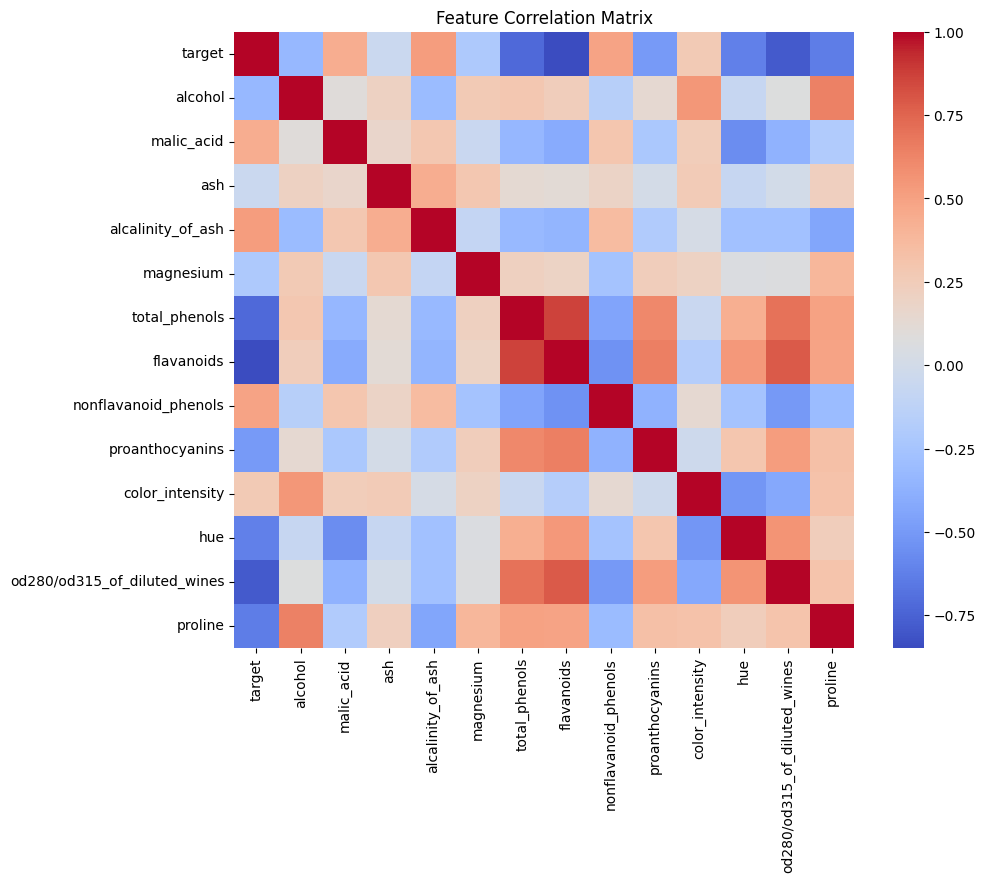

In [ ]:
# feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

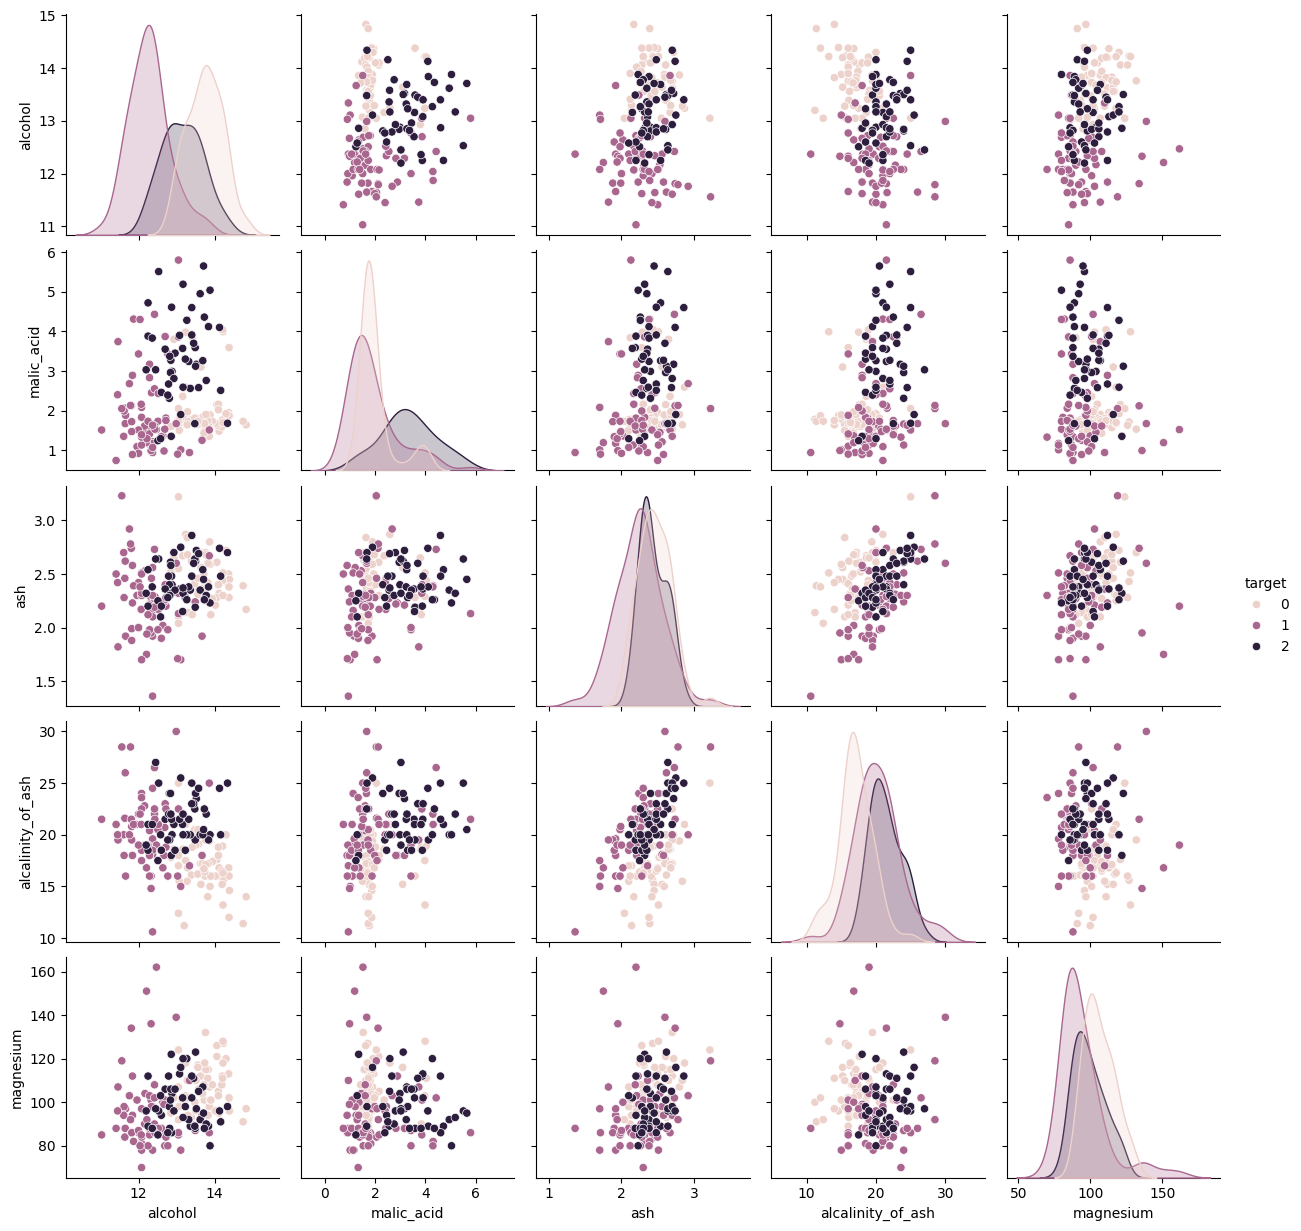

In [23]:
# pairplots first 5 features
sns.pairplot(df, hue='target', vars=wine_data.feature_names[:5])  # just a few features

# Preprocessing

In [59]:
X = df.drop(columns=["target"]).values
y = df["target"].values

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25 * 0.8 = 0.2 total

# NN Architecture

In [60]:
class MyMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [61]:
input_dim = X.shape[1]
hidden_dim = 16
output_dim = len(np.unique(y)) 
layer_sizes = [input_dim, hidden_dim, output_dim]

model = MyMLP(input_dim, hidden_dim, output_dim)

In [62]:
# GD optimizer parameters
results_gd = gd_nn(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    loss_type="cross_entropy",
    optimizer_type="adam",  # or "sgd"
    lr=0.01,
    batch_size=32,
    epochs=100,
    tol=1e-6,
    track_val_loss=True,
    track_weight_norm=True,
    track_val_accuracy=True,
    early_stopping=True,
    patience=10,
    min_delta=1e-4,
    device="cpu",
    verbose=True
)

[Epoch 0] New best val loss: 0.868833
[Epoch 1] New best val loss: 0.683291
[Epoch 2] New best val loss: 0.493534
[Epoch 3] New best val loss: 0.326857
[Epoch 4] New best val loss: 0.200696
[Epoch 5] New best val loss: 0.126522
[Epoch 6] New best val loss: 0.086339
[Epoch 7] New best val loss: 0.064846
[Epoch 8] New best val loss: 0.053295
[Epoch 9] New best val loss: 0.047636
[Epoch 10] New best val loss: 0.043574
[Epoch 11] New best val loss: 0.040861
[Epoch 12] New best val loss: 0.038463
[Epoch 13] New best val loss: 0.036642
[Epoch 14] New best val loss: 0.035552
[Epoch 15] New best val loss: 0.034774
[Epoch 16] New best val loss: 0.034473
[Epoch 17] New best val loss: 0.034086
[Epoch 18] New best val loss: 0.033491
[Epoch 19] New best val loss: 0.032585
[Epoch 20] New best val loss: 0.031772
[Epoch 21] New best val loss: 0.031287
[Epoch 22] New best val loss: 0.030976
[Epoch 23] New best val loss: 0.030567
[Epoch 25] New best val loss: 0.030384
[Epoch 26] New best val loss: 0.030

In [63]:
# unpack results
best_x = results_gd[0]
best_weights = unflatten_weights(best_x, layer_sizes)

In [64]:
# function to load weights into PyTorch model
def load_weights_into_model(model: nn.Module, weights: list):
    with torch.no_grad():
        for (W, b), layer in zip(weights, model.children().__next__()):
            if isinstance(layer, nn.Linear):
                layer.weight.copy_(torch.tensor(W.T, dtype=torch.float32))  # note the transpose!
                layer.bias.copy_(torch.tensor(b, dtype=torch.float32))

# load weights into the trained model
load_weights_into_model(model, best_weights)

In [65]:
# Set model to evaluation mode
model.eval()

# Convert X_test to torch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Get model predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

In [66]:
# Accuracy
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4722
